# 2D Advection-Diffusion equation

in this notebook we provide a simple example of the DeepMoD algorithm and apply it on the 2D advection-diffusion equation. 

In [1]:
# General imports
import numpy as np
import torch
import matplotlib.pylab as plt

# DeepMoD functions

from deepymod import DeepMoD
from deepymod.model.func_approx import NN, Siren
from deepymod.model.library import Library2D_third
from deepymod.model.constraint import LeastSquares
from deepymod.model.sparse_estimators import Threshold,PDEFIND
from deepymod.training import train
from deepymod.training.sparsity_scheduler import TrainTestPeriodic
from scipy.io import loadmat

# Settings for reproducibility
np.random.seed(40)
torch.manual_seed(0)


%load_ext autoreload
%autoreload 2

## Prepare the data

Next, we prepare the dataset.

In [24]:
data_pre = np.load('../diffusion_advection_29longb.npy').T
data= data_pre[120:-60,:,5:30]
down_data= np.take(np.take(np.take(data,np.arange(0,data.shape[0],8),axis=0),np.arange(0,data.shape[1],8),axis=1),np.arange(0,data.shape[2],1),axis=2)

steps = down_data.shape[2]
width = down_data.shape[0]
width_2 = down_data.shape[1]

x_arr = np.arange(0,width)
y_arr = np.arange(0,width_2)
t_arr = np.arange(0,steps)
x_grid, y_grid, t_grid = np.meshgrid(x_arr, y_arr, t_arr, indexing='ij')
down_data.shape

(15, 19, 25)

In [25]:
X = np.transpose((t_grid.flatten()/np.max(t_grid), x_grid.flatten()/np.max(y_grid), y_grid.flatten()/np.max(y_grid)))
y = np.float32(down_data.reshape((down_data.size, 1)))
y = y/np.max(y)
y.shape

(7125, 1)

In [26]:
number_of_samples = 5000

idx = np.random.permutation(y.shape[0])
X_train = torch.tensor(X[idx, :][:number_of_samples], dtype=torch.float32, requires_grad=True)
y_train = torch.tensor(y[idx, :][:number_of_samples], dtype=torch.float32)

## Configuration of DeepMoD

In [27]:
network = NN(3, [40, 40, 40, 40], 1)
library = Library2D_third(poly_order=0) 
estimator = Threshold(0.025) 
sparsity_scheduler = TrainTestPeriodic(periodicity=50, patience=200, delta=1e-5) 
constraint = LeastSquares() 

Now we instantiate the model and select the optimizer 

In [28]:
model = DeepMoD(network, library, estimator, constraint)
optimizer = torch.optim.Adam(model.parameters(), betas=(0.99, 0.99), amsgrad=True, lr=2e-3) 

## Run DeepMoD 

We can now run DeepMoD using all the options we have set and the training data:
* The directory where the tensorboard file is written (log_dir)
* The ratio of train/test set used (split)
* The maximum number of iterations performed (max_iterations)
* The absolute change in L1 norm considered converged (delta)
* The amount of epochs over which the absolute change in L1 norm is calculated (patience)

In [29]:
train(model, X_train, y_train, optimizer,sparsity_scheduler, log_dir='runs/check_15/', split=0.8, max_iterations=10000, delta=1e-6, patience=200) 

  9975  MSE: 2.61e-04  Reg: 1.44e-05  L1: 1.49e+00 Algorithm converged. Writing model to disk.


In [30]:
print(model.estimator_coeffs())

[array([[ 0.        ],
       [ 0.97748464],
       [-0.03695104],
       [ 0.12719823],
       [ 0.34590614],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]], dtype=float32)]


Sparsity masks provide the active and non-active terms in the PDE:

In [31]:
sol = model(torch.tensor(X, dtype=torch.float32))[0].reshape((width,width_2,steps)).detach().numpy()

In [32]:
ux = model(torch.tensor(X, dtype=torch.float32))[2][0][:,1].reshape((width,width_2,steps)).detach().numpy()
uy = model(torch.tensor(X, dtype=torch.float32))[2][0][:,2].reshape((width,width_2,steps)).detach().numpy()

In [33]:
ut = model(torch.tensor(X, dtype=torch.float32))[1][0].reshape((width,width_2,steps)).detach().numpy()

In [34]:
uxx = model(torch.tensor(X, dtype=torch.float32))[2][0][:,3].reshape((width,width_2,steps)).detach().numpy()
uyy = model(torch.tensor(X, dtype=torch.float32))[2][0][:,4].reshape((width,width_2,steps)).detach().numpy()

In [35]:
import pysindy as ps

In [36]:
fd_spline = ps.SINDyDerivative(kind='spline', s=1e-2)
fd_spectral = ps.SINDyDerivative(kind='spectral')
fd_sg = ps.SINDyDerivative(kind='savitzky_golay', left=0.5, right=0.5, order=3)

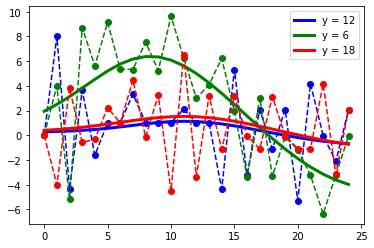

In [40]:
y = down_data[7,5,:]
t = t_arr
plt.plot(t,fd_sg(y,t), 'bo--')
plt.plot(t,ut[7,5,:]*np.max(down_data)/np.max(t_grid),'b', label='y = 12',linewidth=3)
y = down_data[7,10,:]
t = t_arr
plt.plot(t,fd_sg(y,t), 'go--')
plt.plot(t,ut[7,10,:]*np.max(down_data)/np.max(t_grid),'g', label='y = 6',linewidth=3)
y = down_data[7,15,:]
t = t_arr
plt.plot(t,fd_sg(y,t), 'ro--')
plt.plot(t,ut[7,15,:]*np.max(down_data)/np.max(t_grid),'r', label='y = 18',linewidth=3)
plt.legend()

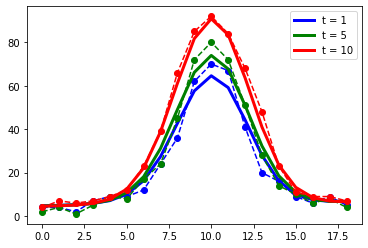

In [41]:
y = down_data[10,:,1]
x = y_arr
plt.plot(x,y, 'bo--')
plt.plot(x,sol[10,:,1]*np.max(down_data),'b', label='t = 1',linewidth=3)
y = down_data[10,:,2]
x = y_arr
plt.plot(x,y, 'go--')
plt.plot(x,sol[10,:,2]*np.max(down_data),'g', label='t = 5',linewidth=3)
y = down_data[10,:,4]
x = y_arr
plt.plot(x,y, 'ro--')
plt.plot(x,sol[10,:,4]*np.max(down_data),'r', label='t = 10',linewidth=3)
plt.legend()

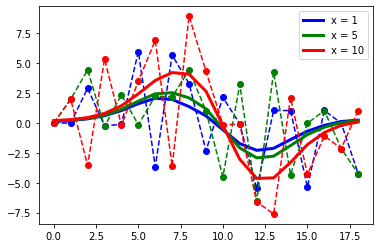

In [38]:
y = down_data[7,:,1]
x = y_arr
plt.plot(x,fd_sg(y,x), 'bo--')
plt.plot(x,uy[7,:,1]*np.max(down_data)/np.max(y_grid),'b', label='x = 1',linewidth=3)
y = down_data[7,:,2]
x = y_arr
plt.plot(x,fd_sg(y,x), 'go--')
plt.plot(x,uy[7,:,2]*np.max(down_data)/np.max(y_grid),'g', label='x = 5',linewidth=3)
y = down_data[7,:,4]
x = y_arr
plt.plot(x,fd_sg(y,x), 'ro--')
plt.plot(x,uy[7,:,4]*np.max(down_data)/np.max(y_grid),'r', label='x = 10',linewidth=3)
plt.legend()

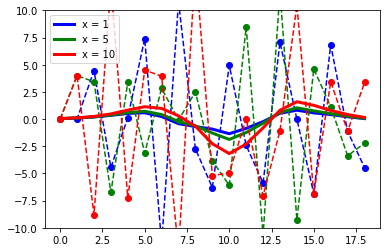

In [39]:
y = down_data[7,:,1]
x = y_arr
plt.plot(x,fd_sg(fd_sg(y,x)), 'bo--')
plt.plot(x,uyy[7,:,1]*np.max(down_data)/(np.max(y_grid)*np.max(y_grid)),'b',label='x = 1',linewidth=3)
y = down_data[7,:,2]
x = y_arr
plt.plot(x,fd_sg(fd_sg(y,x)), 'go--')
plt.plot(x,uyy[7,:,2]*np.max(down_data)/(np.max(y_grid)*np.max(y_grid)),'g',label='x = 5',linewidth=3)
y = down_data[7,:,4]
x = y_arr
plt.plot(x,fd_sg(fd_sg(y,x)), 'ro--')
plt.plot(x,uyy[7,:,4]*np.max(down_data)/(np.max(y_grid)*np.max(y_grid)),'r',label='x = 10',linewidth=3)
plt.ylim(-10,10)
plt.legend()

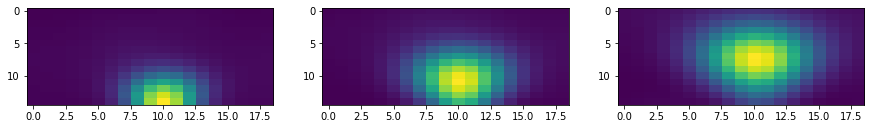

In [42]:
fig = plt.figure(figsize=(15,5))

plt.subplot(1,3, 1)
plt.imshow(sol[:,:,1], aspect=0.5)

plt.subplot(1,3, 2)
plt.imshow(sol[:,:,10], aspect=0.5)

plt.subplot(1,3, 3)
plt.imshow(sol[:,:,19], aspect=0.5)


#plt.savefig('reconstruction.pdf')

In [357]:
import pysindy as ps

In [358]:
fd_spline = ps.SINDyDerivative(kind='spline', s=1e-2)
fd_spectral = ps.SINDyDerivative(kind='spectral')
fd_sg = ps.SINDyDerivative(kind='savitzky_golay', left=0.5, right=0.5, order=3)

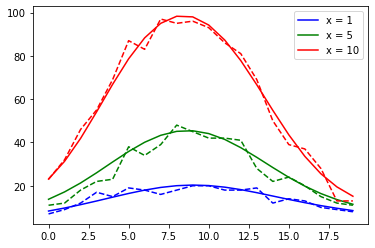

In [359]:
y = down_data[2,:,19]
x = x_arr
plt.plot(x,y, 'b--')
plt.plot(x,sol[2,:,19]*np.max(down_data),'b', label='x = 1')
y = down_data[5,:,19]
x = x_arr
plt.plot(x,y, 'g--')
plt.plot(x,sol[5,:,19]*np.max(down_data),'g', label='x = 5')
y = down_data[11,:,19]
x = x_arr
plt.plot(x,y, 'r--')
plt.plot(x,sol[11,:,19]*np.max(down_data),'r', label='x = 10')
plt.legend()

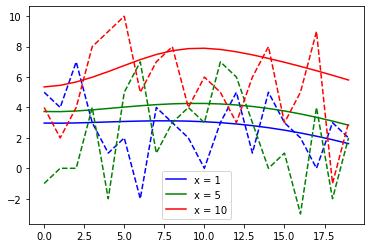

In [360]:
y = down_data[1,:,1]
x = x_arr
plt.plot(x,y, 'b--')
plt.plot(x,sol[1,:,1]*np.max(down_data),'b', label='x = 1')
y = down_data[5,:,1]
x = x_arr
plt.plot(x,y, 'g--')
plt.plot(x,sol[5,:,1]*np.max(down_data),'g', label='x = 5')
y = down_data[11,:,1]
x = x_arr
plt.plot(x,y, 'r--')
plt.plot(x,sol[11,:,1]*np.max(down_data),'r', label='x = 10')
plt.legend()

In [7]:
np.max(down_data)/100

1.38

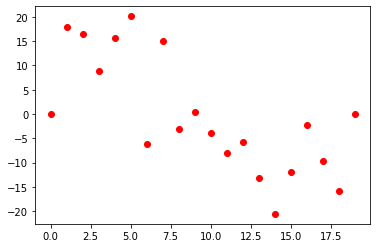

In [331]:
plt.plot(x,fd_sg(y,x), 'ro')

In [6]:
y = down_data[1,:,19]
x = x_arr
plt.plot(x,fd_sg(y,x), 'b--')
plt.plot(x,uy[1,:,19]*np.max(down_data)/100,'b', label='x = 1')
y = down_data[5,:,19]
x = x_arr
plt.plot(x,fd_sg(y,x), 'g--')
plt.plot(x,uy[5,:,19]*np.max(down_data)/100,'g', label='x = 5')
y = down_data[10,:,19]
x = x_arr
plt.plot(x,fd_sg(y,x), 'r--')
plt.plot(x,uy[10,:,19]*np.max(down_data)/100,'r', label='x = 10')
plt.legend()

NameError: name 'x_arr' is not defined

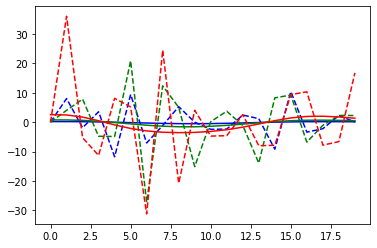

In [337]:
y = down_data[2,:,19]
x = x_arr
plt.plot(x,fd_sg(fd_sg(y,x)), 'b--')
plt.plot(x,uyy[2,:,19]*np.max(down_data)/(100*100),'b')
y = down_data[5,:,19]
x = x_arr
plt.plot(x,fd_sg(fd_sg(y,x)), 'g--')
plt.plot(x,uyy[5,:,19]*np.max(down_data)/(100*100),'g')
y = down_data[11,:,19]
x = x_arr
plt.plot(x,fd_sg(fd_sg(y,x)), 'r--')
plt.plot(x,uyy[11,:,19]*np.max(down_data)/(100*100),'r')

In [ ]:


fig = plt.figure(figsize=(15,5))

plt.subplot(1,3, 1)
y = down_data[2,:,2]
x = x_arr
plt.plot(x,y)
plt.plot(x,sol[2,:,2]*np.max(down_data))
plt.legend()

plt.subplot(1,3, 2)
y = down_data[2,:,2]
x = x_arr
plt.plot(x,y)
plt.plot(x,sol[2,:,2]*np.max(down_data))

plt.subplot(1,3, 3)
y = down_data[2,:,2]
x = x_arr
plt.plot(x,y)
plt.plot(x,sol[2,:,2]*np.max(down_data))
plt.legend()

plt.show()

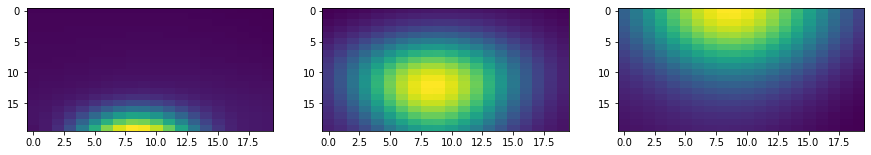

In [352]:
fig = plt.figure(figsize=(15,5))

plt.subplot(1,3, 1)
plt.imshow(sol[:,:,1], aspect=0.5)

plt.subplot(1,3, 2)
plt.imshow(sol[:,:,19], aspect=0.5)

plt.subplot(1,3, 3)
plt.imshow(sol[:,:,39], aspect=0.5)


plt.savefig('reconstruction.pdf')

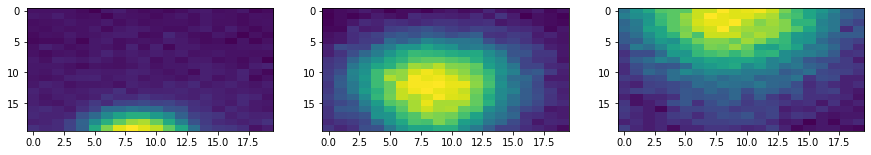

In [353]:
fig = plt.figure(figsize=(15,5))

plt.subplot(1,3, 1)
plt.imshow(down_data[:,:,1], aspect=0.5)

plt.subplot(1,3, 2)
plt.imshow(down_data[:,:,19], aspect=0.5)

plt.subplot(1,3, 3)
plt.imshow(down_data[:,:,39], aspect=0.5)

plt.savefig('original_20_20_40.pdf')

In [290]:
np.max(down_data)

138.0

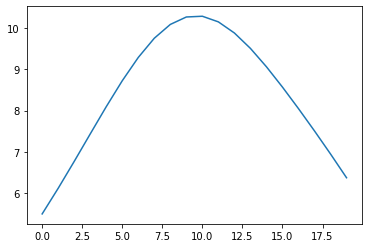

In [294]:
plt.plot(x,sol[5,:,10]*np.max(down_data))

In [29]:
noise_level = 0.025
y_noisy = y + noise_level * np.std(y) * np.random.randn(y.size)

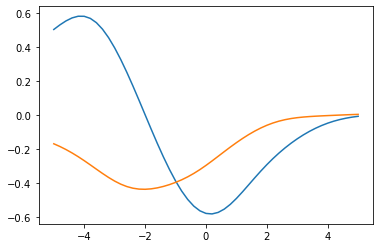

In [27]:
plt.plot(x,uy[25,:,10])
plt.plot(x,ux[25,:,10])

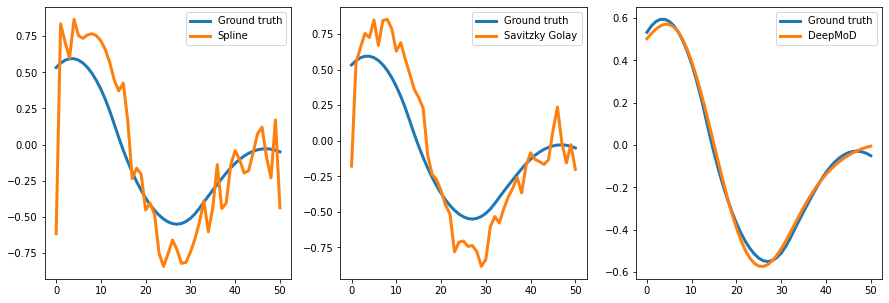

In [29]:
fig = plt.figure(figsize=(15,5))

plt.subplot(1,3, 1)
plt.plot(fd_spline(y.reshape(-1,1),x), label='Ground truth',linewidth=3)
plt.plot(fd_spline(y_noisy.reshape(-1,1),x), label='Spline',linewidth=3)
plt.legend()

plt.subplot(1,3, 2)
plt.plot(fd_spline(y.reshape(-1,1),x), label='Ground truth',linewidth=3)
plt.plot(fd_sg(y_noisy.reshape(-1,1),x), label='Savitzky Golay',linewidth=3)
plt.legend()

plt.subplot(1,3, 3)
plt.plot(fd_spline(y.reshape(-1,1),x), label='Ground truth',linewidth=3)
plt.plot(uy[25,:,10],linewidth=3, label='DeepMoD')
plt.legend()

plt.show()

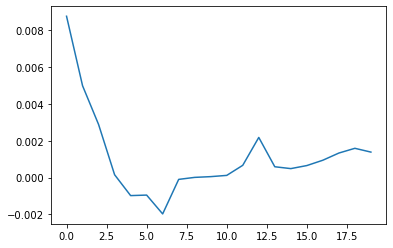

In [143]:
plt.plot(ux[10,:,5])
ax = plt.subplot(1,1,1)
ax.plot(fd(y.reshape(-1,1),x), label='Ground truth')
ax.plot(fd_sline(y_noisy.reshape(-1,1),x), label='Spline')
ax.plot(fd_sg(y_noisy.reshape(-1,1),x), label='Savitzky Golay')
ax.legend()

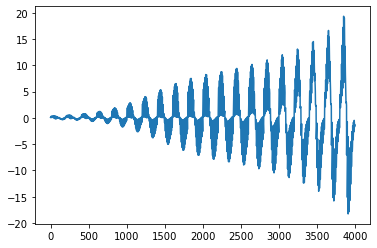

In [55]:
plt.plot(model(torch.tensor(X, dtype=torch.float32))[2][0].detach().numpy())

In [48]:
sol = model(torch.tensor(X, dtype=torch.float32))[0]

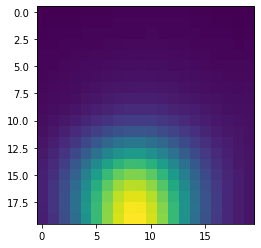

In [25]:
plt.imshow(sol[:,:,4].detach().numpy())

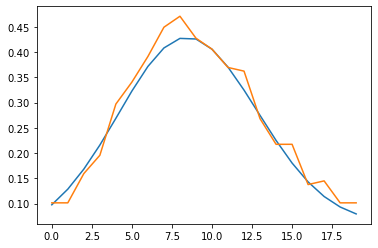

In [34]:
plt.plot(sol[10,:,6].detach().numpy())
plt.plot(down_data[10,:,6]/np.max(down_data))

In [73]:
x = np.arange(0,len(y))

In [76]:
import pysindy as ps
diffs = [
    ('PySINDy Finite Difference', ps.FiniteDifference()),
    ('Smoothed Finite Difference', ps.SmoothedFiniteDifference()),
    ('Savitzky Golay', ps.SINDyDerivative(kind='savitzky_golay', left=0.5, right=0.5, order=3)),
    ('Spline', ps.SINDyDerivative(kind='spline', s=1e-2)),
    ('Trend Filtered', ps.SINDyDerivative(kind='trend_filtered', order=0, alpha=1e-2)),
    ('Spectral', ps.SINDyDerivative(kind='spectral')),
]

In [117]:
fd = ps.SINDyDerivative(kind='spline', s=1e-2)

In [125]:
y = down_data[:,10,9]/np.max(down_data)

In [126]:
x = np.arange(0,len(y))

In [127]:
t = np.linspace(0,1,5)
X = np.vstack((np.sin(t),np.cos(t))).T

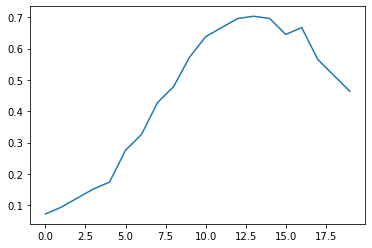

In [128]:
plt.plot(y)

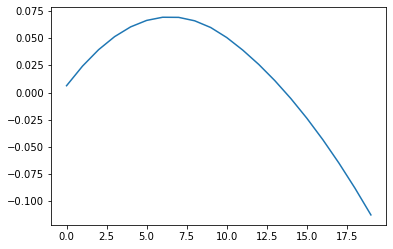

In [133]:
plt.plot(fd(y.reshape(-1,1),x))

In [129]:
y.shape

(20,)

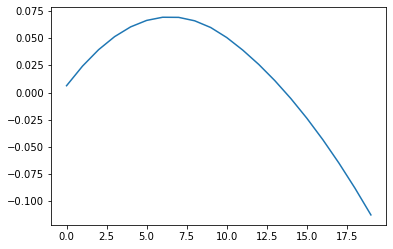

In [130]:
plt.plot(fd._differentiate(y.reshape(-1,1),x))


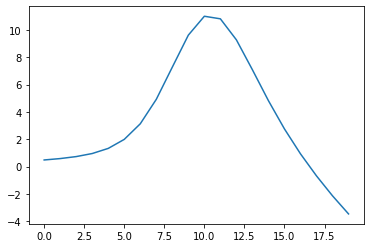

In [124]:
plt.plot(ux[:,10,6])

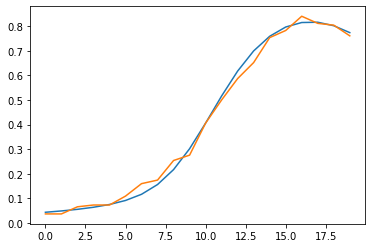

In [33]:
plt.plot(sol[:,10,6].detach().numpy())
plt.plot(down_data[:,10,6]/np.max(down_data))

In [19]:
model.sparsity_masks

[tensor([ True,  True, False,  True,  True, False,  True, False, False, False,
         False, False], device='cuda:0')]

estimatior_coeffs gives the magnitude of the active terms:

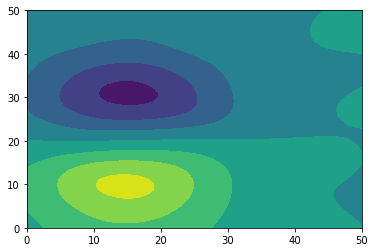

In [112]:
plt.contourf(ux[:,:,10])

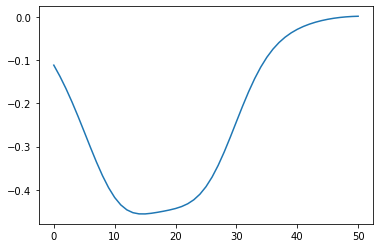

In [119]:
plt.plot(ux[25,:,2])

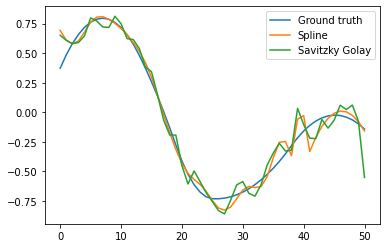

In [117]:
ax = plt.subplot(1,1,1)
ax.plot(fd(y.reshape(-1,1),x), label='Ground truth')
ax.plot(fd_sline(y_noisy.reshape(-1,1),x), label='Spline')
ax.plot(fd_sg(y_noisy.reshape(-1,1),x), label='Savitzky Golay')
ax.legend()

In [15]:
import pysindy as ps

In [77]:
fd_spline = ps.SINDyDerivative(kind='spline', s=1e-2)
fd_spectral = ps.SINDyDerivative(kind='spectral')
fd_sg = ps.SINDyDerivative(kind='savitzky_golay', left=0.5, right=0.5, order=3)

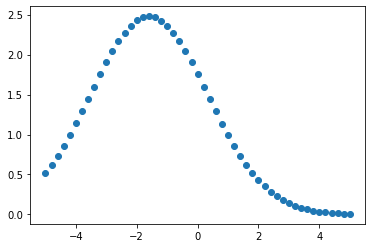

In [52]:
y = u_v[25,:,2]
x = y_v[25,:,2]
plt.scatter(x,y)

In [53]:
y.shape

(51,)

In [62]:
noise_level = 0.025
y_noisy = y + noise_level * np.std(y) * np.random.randn(y.size)

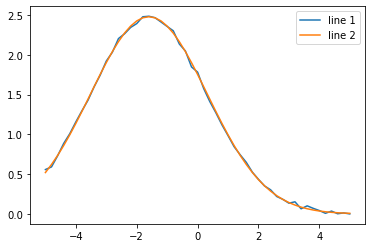

In [75]:
ax = plt.subplot(1,1,1)
ax.plot(x,y_noisy, label="line 1")
ax.plot(x,y, label="line 2")
ax.legend()

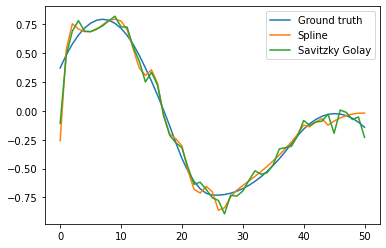

In [80]:
ax = plt.subplot(1,1,1)
ax.plot(fd(y.reshape(-1,1),x), label='Ground truth')
ax.plot(fd_sline(y_noisy.reshape(-1,1),x), label='Spline')
ax.plot(fd_sg(y_noisy.reshape(-1,1),x), label='Savitzky Golay')
ax.legend()
